# Importing libraries

In [3]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.cluster import AgglomerativeClustering
from transformers import AutoTokenizer, AutoModel
import scipy.cluster.hierarchy as sch
import matplotlib.pyplot as plt
import torch
import nltk
from lazypredict.Supervised import LazyClassifier
from nltk.corpus import stopwords
import spacy
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer, WordNetLemmatizer
import string
from wordcloud import WordCloud
from nltk import bigrams
from nltk.collocations import BigramAssocMeasures
from nltk.probability import FreqDist
import gensim
import gensim.corpora as corpora
from gensim.models import CoherenceModel
# visualization
import pyLDAvis
import pyLDAvis.gensim_models
from pprint import pprint
import pyLDAvis.gensim_models as gensimvis
import networkx as nx
from nltk.collocations import BigramAssocMeasures, BigramCollocationFinder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, roc_curve
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report
from imblearn.over_sampling import RandomOverSampler
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import ComplementNB, GaussianNB, MultinomialNB
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF, DotProduct
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF, DotProduct
from sklearn.naive_bayes import ComplementNB, GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from scipy.stats import loguniform
import seaborn as sns
import torch
from transformers import BertTokenizer, BertForSequenceClassification
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import accuracy_score
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer

# Helper: pipelines

In [4]:
def remove_columns(df, columns_to_remove = ['AP','Ariadne_internal_ID','cnt','OOC (out of category)', 'Comment', 'Conditional Formatting']):
    # Drop the specified columns
    df = df.drop(columns=columns_to_remove, axis=1, errors='ignore')
    return df

def remove_missing_data(df, column='content'):
    # Check for missing data in the entire DataFrame
    missing_data = df.isnull().sum()
    if (missing_data > 0).sum()>0:
        # Print missing data counts for each column
        print("Missing Data Counts:")
        print(missing_data)
        df.dropna(subset=['content'], inplace=True)
    return df

def remove_duplicate_data(df):
    # Check for duplicate rows
    duplicate_rows = df[df.duplicated()]
    if duplicate_rows.shape[0]>0:
        # Print duplicate rows
        #print("Duplicate Rows:")
        #print(duplicate_rows)
        df.drop_duplicates(inplace=True)
    return df
        
nlp = spacy.load('de_core_news_sm')
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

def remove_punctuation(df, column='content'):
    df['content'] = df['content'].apply(lambda x: ' '.join([token.text for token in nlp(x) if token.pos_!='PROPN']))
    df['content'] = df['content'].apply(lambda x: x.translate(str.maketrans('', '', string.punctuation)))
    return df

def preprocess_text(content):
    # Initialize the Snowball stemmer and WordNet lemmatizer
    stemmer = SnowballStemmer("german")  # Use the appropriate language for stemming
    lemmatizer = WordNetLemmatizer()

    # Tokenize the content
    tokens = word_tokenize(content)
    tokens = [word.lower() for word in tokens if word.isalnum()]
    
    # Remove stopwords
    stop_words = set(stopwords.words('german'))  # Use the appropriate language
    tokens = [word for word in tokens if word not in stop_words]
    
    # Remove short words (length < 3 characters)
    tokens = [word for word in tokens if len(word) > 2]
    
    # Lemmatize or stem the words
    # Uncomment one of the following lines based on your choice
    # tokens = [lemmatizer.lemmatize(word) for word in tokens]  # Lemmatization
    tokens = [stemmer.stem(word) for word in tokens]  # Stemming
    
    # Join the cleaned tokens back into a single string
    cleaned_content = ' '.join(tokens)
    
    return cleaned_content

def process_text(df):
    # Apply the preprocessing function to the DataFrame
    df['content'] = df['content'].apply(preprocess_text)
    return df

def get_unique_number_of_words(df):
    word_set = set()
    for row in df["content"]:
        word_set.update(row.split(" "))
    print('Unique number of words:', len(word_set))
    return df

def remove_frequent_words(df):
    # select the 100 most frequent words
    most_frequent = Counter(" ".join(df["content"]).split()).most_common(100)
    print([el[0] for el in most_frequent])

    # Words to remove
    words_to_remove =  most_frequent + ["herr", "hallo", "willkomm", "herzlich", "mal", "tun", "tag", "nam", "guck", "sau", "bitt", 
                                       "halt", "gerad", "weil", "desweg", "gruss", "schon", "abend", "irgendwie", "schau", "nachmittag", "aha",
                                       "gott", "frau", "opus", "herrn", "irgendwo", 'bitt', 'mal', 'schon', 'genau', 'dank', 'gut', 'tag', 'numm', 'person', 'kurz', 
                       'einfach', 'neu', 'schau', 'moment', 'sag', 'muss', 'geht', 'fall', 'ganz', 'war', 'gern', 'frag', 
                       'gleich',
                      'guck', 'imm', 'halt', 'wurd', 'seh', 'natur', 'quasi', 'gerad', 'bekomm', 'rout', 'gesagt', 'nein', 
                       'tun', 'syst',
                      'mehr', 'mocht', 'box', 'geh', 'zugangsdat', 'passwort', 'kennwort', 'steht','seit', 'klein', 'bekomm', 'rufnumm', 
                       'kundenkennzahl', 'leid', 'tun', 'nam', 'per', 'willkomm', 'herzlich', 'gemacht', 'bleib', 'herr',
                       'kolleg',
                       'schick', 'frau', 'geb', 'richtig', 'vielleicht', 'viel','kart', 'brot', 'brauch',
                      'erst', 'gibt', 'kommt', 'moglich',  'pro', 'iphon', 'sekund', 'minut', 'wirklich', 'krieg',
                       'tatsach', 'musst', 'weiss',  'darf', 'find', 'gar', 'probl' , 'nee', 'klar', 'tschuss', 'heut', 'uhr', 'anruf', 
                       'wunsch', 'dat' , 'hallo', 'kundig', 'ich', 'habe']


    # Function to remove specified words from content
    def remove_specific_words(content, words_to_remove):
        # Tokenize the content
        tokens = content.split(" ")

        # Filter out words to remove
        filtered_tokens = [word for word in tokens if word not in words_to_remove]

        # Join the remaining tokens back into a single string
        cleaned_content = ' '.join(filtered_tokens)
        return cleaned_content

    # Apply the function to the 'cleaned_text' column
    df['content'] = df['content'].apply(lambda x: remove_specific_words(x, words_to_remove))
    return df

def tokenize_with_sliding_window(content, window_size=512, step_size=256):
    tokens = []
    for i in range(0, len(content), step_size):
        chunk = content[i:i + window_size]
        tokens.extend(tokenizer.encode(chunk, add_special_tokens=True))
    return tokens

def encode_bert(content, labels, tokenizer):
    encoding = tokenizer(content, truncation=True, padding='max_length', max_length=max_length, return_tensors='pt')
    return pd.DataFrame([[encoding['input_ids'].flatten(), encoding['attention_mask'].flatten(),
                          torch.tensor(labels, dtype=torch.float32)]],
                        columns = ['input_ids', 'attention_mask', 'labels'])

def prepare_bert(df, targets):
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    df['content'] = df['content'].apply(lambda x: tokenize_with_sliding_window(x, window_size, step_size, tokenizer))
    df[['input_ids', 'attention_mask', 'labels']] = df.apply(lambda x: encode_bert(x['content'], x[targets], tokenizer))
    return df
                          
def calculate_word_count(df):
    # Split the 'content' column into words and calculate word counts
    df['word_count'] = df['content'].apply(lambda x: len(str(x).split()))

    # Calculate the average word count
    average_word_count = df['word_count'].mean()

    # Print the average word count
    print("Average Word Count:", average_word_count)

    # Calculate the average word count
    average_word_count_median = df['word_count'].median()

    # Print the average word count
    print("Median Word Count:", average_word_count_median)


    # Print the max word count
    print("Max Word Count:", df['word_count'].max())

    # Print the min word count
    print("Min Word Count:", df['word_count'].min())
    
    # Find the content with the minimum number of words
    min_word_count = df['word_count'].min()
    min_word_text = df[df['word_count'] == min_word_count]['content'].values[0]

    # Print the content with the minimum word count
    print("Text with the Minimum Number of Words:")
    print(min_word_text)

    # Optionally, you can also print the word count for reference
    print(f"Word Count: {min_word_count}")
    
    # Create a histogram of the word counts
    plt.hist(df['word_count'], bins=20, edgecolor='k', alpha=0.7)
    plt.xlabel('Number of Words')
    plt.ylabel('Frequency')
    plt.title('Histogram of Word Counts in Texts')
    plt.show()

    return df


C:\Users\Muhammad Farhan\anaconda\Lib\site-packages\catalogue\__init__.py:135: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
C:\Users\Muhammad Farhan\anaconda\Lib\site-packages\catalogue\__init__.py:135: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
C:\Users\Muhammad Farhan\anaconda\Lib\site-packages\catalogue\__init__.py:135: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
C:\Users\Muhammad Farhan\anaconda\Lib\site-packages\catalogue\__init__.py:135: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
C:\Users\Muhammad Farhan\anaconda\Lib\site-p

C:\Users\Muhammad Farhan\anaconda\Lib\site-packages\catalogue\__init__.py:123: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
C:\Users\Muhammad Farhan\anaconda\Lib\site-packages\catalogue\__init__.py:123: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
C:\Users\Muhammad Farhan\anaconda\Lib\site-packages\catalogue\__init__.py:123: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
C:\Users\Muhammad Farhan\anaconda\Lib\site-packages\catalogue\__init__.py:123: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
C:\Users\Muhammad Farhan\anaconda\Lib\site-p

C:\Users\Muhammad Farhan\anaconda\Lib\site-packages\catalogue\__init__.py:123: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
C:\Users\Muhammad Farhan\anaconda\Lib\site-packages\catalogue\__init__.py:123: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
C:\Users\Muhammad Farhan\anaconda\Lib\site-packages\catalogue\__init__.py:123: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
C:\Users\Muhammad Farhan\anaconda\Lib\site-packages\catalogue\__init__.py:123: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
C:\Users\Muhammad Farhan\anaconda\Lib\site-p

# Load data

In [5]:
df_unlabeled = pd.read_csv('bq-results-20230912-113230-1694518407919.csv')
df_unlabeled.head(2)

,filename,content,SOM,location,call_duration,Ariadne_internal_ID
0,SOM_118_00513_FA163E622DEB-1a7e-e29da700-832c3...,Herzlich willkommen bei O sein uns am Apparat ...,SOM,118,513,FA163E622DEB-1a7e-e29da700-832c3-64e3520f-7cef...
1,SOM_118_00513_FA163E52FD32-1a7e-2da87700-aa52c...,Willkommen bei der O Kundenbetreuung sie sprec...,SOM,118,513,FA163E52FD32-1a7e-2da87700-aa52c-64e76b65-aec3...


In [6]:
df1 = pd.read_excel('231106_Labeling KI Files_x1121.xlsx')
df2 = pd.read_excel('2501 - 5000 final.xlsx')
df3 = pd.read_excel('1 - 2500 Fertig 1.xlsx')
df_labeled = pd.concat([df1, df2, df3], ignore_index=True)
df_labeled.head(2)

,AP,Ariadne_internal_ID,content,cnt,VVL Mobile,VVL DSL,PO GA,I@H GA,TV GA,OOC (out of category),Comment,Conditional Formatting,Bearbeitungszeit
0,Katrin Kühne,FA163E153AE3-1b27-eeeaa700-77b26-64e3046f-1555...,Herzlich willkommen beim O Kundenservice mein ...,54,False,False,False,False,False,False,NaN,0,NaN
1,Katrin Kühne,FA163E153AE3-1b27-eeeaa700-77d03-64e3074a-24e4...,Guten Morgen bei O sie sprechen mit Alexandra ...,61,False,False,True,False,False,False,NaN,1,NaN


In [7]:
df = pd.concat([df_labeled, df_unlabeled], axis = 0, ignore_index=True)
df.head(2)

,AP,Ariadne_internal_ID,content,cnt,VVL Mobile,VVL DSL,PO GA,I@H GA,TV GA,OOC (out of category),Comment,Conditional Formatting,Bearbeitungszeit,filename,SOM,location,call_duration
0,Katrin Kühne,FA163E153AE3-1b27-eeeaa700-77b26-64e3046f-1555...,Herzlich willkommen beim O Kundenservice mein ...,54.00,False,False,False,False,False,False,NaN,0.00,NaN,NaN,NaN,NaN,NaN
1,Katrin Kühne,FA163E153AE3-1b27-eeeaa700-77d03-64e3074a-24e4...,Guten Morgen bei O sie sprechen mit Alexandra ...,61.00,False,False,True,False,False,False,NaN,1.00,NaN,NaN,NaN,NaN,NaN


# Data preprocessing

In [8]:
targets = ['Sales', 'VVL Mobile', 'VVL DSL', 'PO GA','I@H GA', 'TV GA']

In [10]:
pipe = Pipeline([('remove_columns', FunctionTransformer(remove_columns, kw_args={'columns_to_remove': ['AP','Ariadne_internal_ID','cnt','OOC (out of category)', 'Comment', 'Conditional Formatting']})),
                 ('remove_missing_data', FunctionTransformer(remove_missing_data, kw_args={'column': 'content'})), 
                 ('remove_duplicate_data', FunctionTransformer(remove_duplicate_data)), 
                 ('remove_punctuation', FunctionTransformer(remove_punctuation, kw_args={'column': 'content'})), 
                 ('process_text', FunctionTransformer(process_text)),
                 ('get_unique_number_of_words', FunctionTransformer(get_unique_number_of_words)),
                 ('remove_frequent_words', FunctionTransformer(remove_frequent_words)),
                 ('calculate_word_count', FunctionTransformer(calculate_word_count)),
                 ], verbose = True)

[Pipeline] .... (step 1 of 8) Processing remove_columns, total=   0.0s
Missing Data Counts:
content                0
VVL Mobile             0
VVL DSL                0
PO GA                  0
I@H GA                 0
TV GA                  0
Bearbeitungszeit    4940
filename            5000
SOM                 5000
location            5000
call_duration       5000
Sales                  0
dtype: int64
[Pipeline]  (step 2 of 8) Processing remove_missing_data, total=   0.0s
[Pipeline]  (step 3 of 8) Processing remove_duplicate_data, total=   0.1s
[Pipeline]  (step 4 of 8) Processing remove_punctuation, total= 3.1min
[Pipeline] ...... (step 5 of 8) Processing process_text, total=   8.7s
Unique number of words: 13740
[Pipeline]  (step 6 of 8) Processing get_unique_number_of_words, total=   0.1s
['mal', 'genau', 'schon', 'bitt', 'gut', 'vertrag', 'bekomm', 'dank', 'kurz', 'tag', 'ganz', 'sag', 'moment', 'fall', 'gern', 'monat', 'rufnumm', 'numm', 'neu', 'schau', 'frag', 'richtig', 'seh', 't

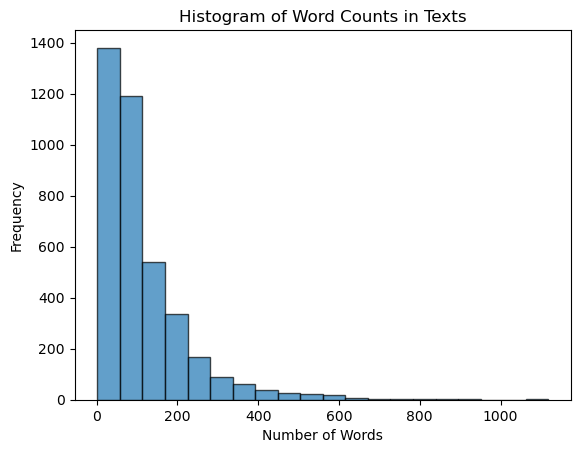

[Pipeline]  (step 8 of 8) Processing calculate_word_count, total=   0.2s


In [11]:
df['Sales'] = df[['VVL Mobile', 'VVL DSL', 'PO GA', 'I@H GA', 'TV GA']].sum(axis=1)>0 

df_processed = pipe.fit_transform(df.iloc[0:5000])

In [12]:
df_labeled = df_processed[pd.notnull(df_processed['VVL Mobile'])].copy()
df_unlabeled = df_processed[pd.isnull(df_processed['VVL Mobile'])].copy()

In [13]:
counts = df_labeled[targets].apply(pd.Series.value_counts)
counts.reset_index(inplace=True)
counts

,index,Sales,VVL Mobile,VVL DSL,PO GA,I@H GA,TV GA
0,False,3128,3736,3863,3329,3843,3790
1,True,754,146,19,553,39,92


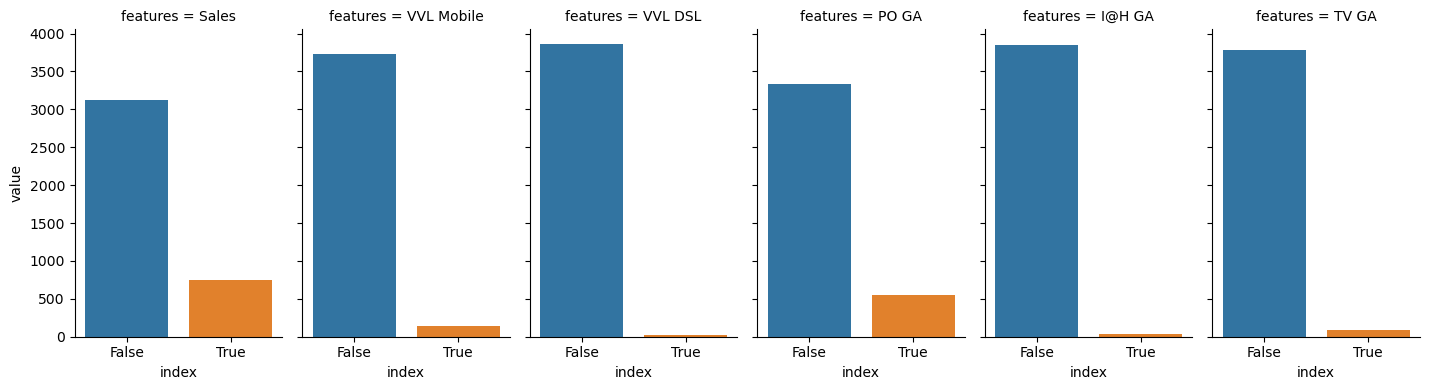

In [14]:
sns.catplot(
    data=counts.melt(id_vars=['index'], var_name='features'), 
    x='index', y='value', col='features',
    kind="bar", height=4, aspect=.6,
)

# Topic Modelling

In [15]:

def perform_topic_modeling(df):
    # Tokenize the text and create a dictionary
    def tokenize(content):
        return content.split()

    texts_content = [tokenize(content) for content in df['content']]

    # Create a dictionary from the tokenized text
    dictionary_content = corpora.Dictionary(texts_content)

    # Create document-term matrices
    corpus_content = [dictionary_content.doc2bow(content) for content in texts_content]

    # Perform LDA
    num_topics =5
    lda_model_content = gensim.models.LdaModel(corpus=corpus_content, id2word=dictionary_content, num_topics=num_topics)

    # Print topics for the 'content' DataFrame
    print("Topics for the 'content' DataFrame:")
    print(lda_model_content.print_topics(num_words=5))

    # Evaluation
    coherence_model_content = CoherenceModel(model=lda_model_content, texts=texts_content, dictionary=dictionary_content, coherence='c_v')
    coherence_content = coherence_model_content.get_coherence()

    # Compute Perplexity a measure of how good the model is. lower the better.
    print('\nContent Perplexity: ', lda_model_content.log_perplexity(corpus_content))  

    # Compute Coherence Score for lda_model_content
    print('\nContent Coherence Score: ', coherence_content)
    
    # Create a function to generate and display word clouds for each topic
    def generate_word_clouds(lda_model, num_topics):
        for topic_num in range(num_topics):
            words = lda_model.show_topic(topic_num, topn=20)  # Get the top 20 words for each topic
            wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(dict(words))

            plt.figure(figsize=(10, 5))
            plt.imshow(wordcloud, interpolation='bilinear')
            plt.title(f"Topic {topic_num}")
            plt.axis("off")
            plt.show()

    # Assuming you have already defined lda_model_content and num_topics
    generate_word_clouds(lda_model_content, num_topics)

    # Assuming you have a list of tokenized texts stored in 'texts_content'
    # Join the tokens back into sentences
    sentences = [' '.join(tokens) for tokens in texts_content]

    # Tokenize the sentences again (if needed)
    tokenized_sentences = [nltk.word_tokenize(sentence) for sentence in sentences]

    # Create a BigramCollocationFinder
    finder = BigramCollocationFinder.from_documents(tokenized_sentences)

    # Set the association measure (you can adjust this)
    bigram_measures = BigramAssocMeasures()
    finder.apply_freq_filter(5)  # Adjust the frequency filter as needed

    # Get the top bigrams
    top_bigrams = finder.nbest(bigram_measures.pmi, 10)  # You can change the number of top bigrams

    # Create a graph to represent word associations
    G = nx.Graph()

    # Add nodes and edges for the bigrams
    for bigram in top_bigrams:
        word1, word2 = bigram
        G.add_node(word1)
        G.add_node(word2)
        G.add_edge(word1, word2)

    # Create a figure and axis explicitly
    plt.figure(figsize=(10, 8))
    ax = plt.gca()

    # Define layout for the nodes
    pos = nx.spring_layout(G)

    # Draw the graph
    nx.draw(G, pos, with_labels=True, font_size=12, node_size=1000, node_color='skyblue', font_color='black', font_weight='bold', ax=ax)
    plt.title("Word Association Graph (Top Bigrams)")
    plt.show()


In [16]:
pipeline_tm = Pipeline([('perform_topic_modeling', FunctionTransformer(perform_topic_modeling))], verbose=True)

In [86]:
pipeline_tm.fit_transform(df_unlabeled)

ValueError: cannot compute LDA over an empty collection (no terms)

Topics for the 'content' DataFrame:
[(0, '0.021*"vertrag" + 0.017*"monat" + 0.015*"tarif" + 0.011*"email" + 0.007*"angebot"'), (1, '0.015*"simkart" + 0.012*"vertrag" + 0.007*"handy" + 0.007*"bewert" + 0.006*"stellig"'), (2, '0.018*"vertrag" + 0.008*"email" + 0.008*"sup" + 0.007*"monat" + 0.006*"simkart"'), (3, '0.020*"vertrag" + 0.012*"monat" + 0.010*"tarif" + 0.008*"email" + 0.007*"beispiel"'), (4, '0.011*"vertrag" + 0.010*"monat" + 0.010*"tarif" + 0.009*"handy" + 0.008*"email"')]

Content Perplexity:  -7.3784320096303055

Content Coherence Score:  0.2873122223915759


/home/wartlick/anaconda3/lib/python3.9/site-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


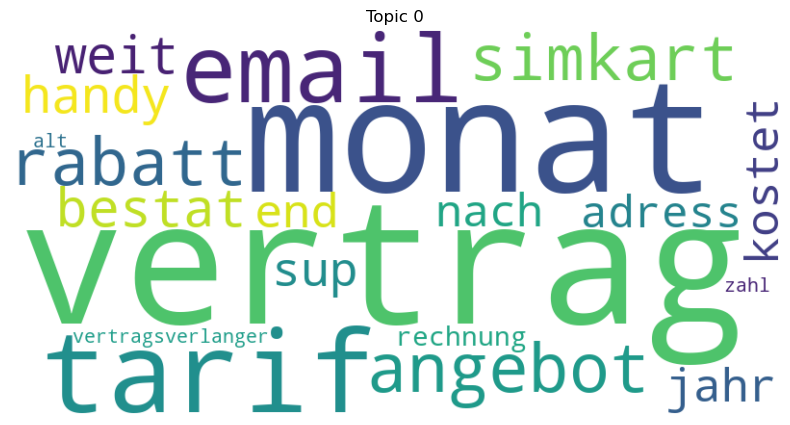

/home/wartlick/anaconda3/lib/python3.9/site-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


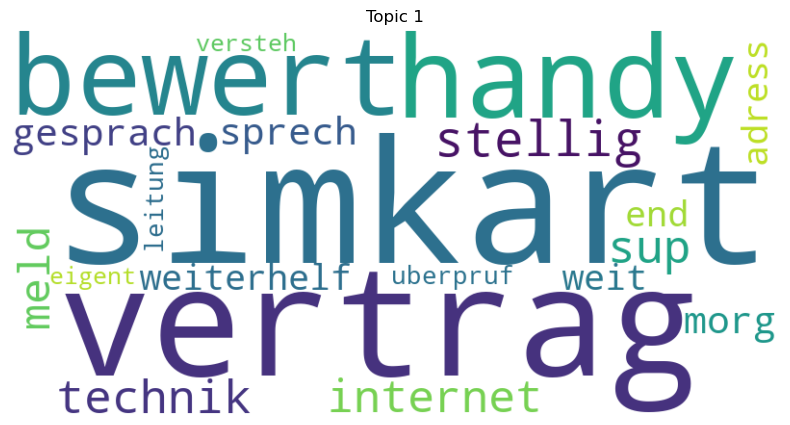

/home/wartlick/anaconda3/lib/python3.9/site-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


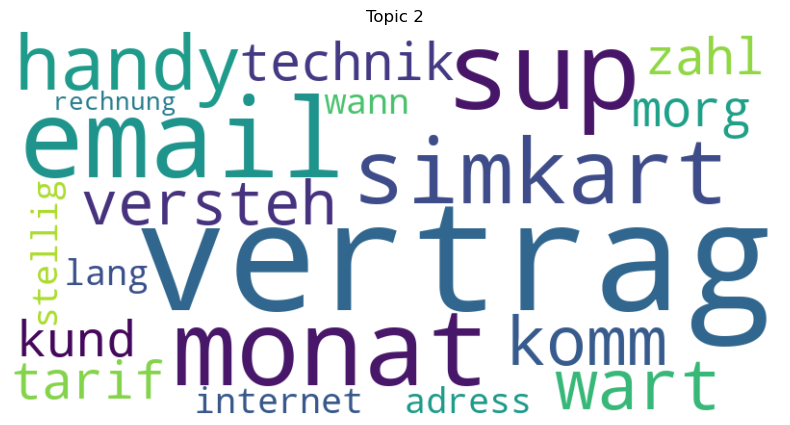

/home/wartlick/anaconda3/lib/python3.9/site-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


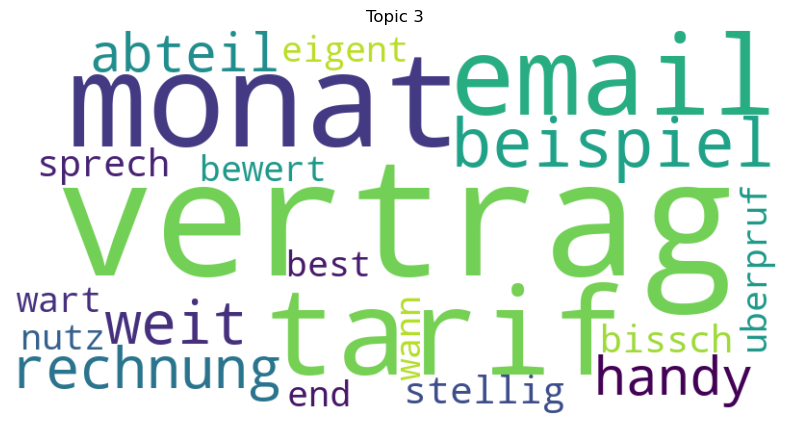

/home/wartlick/anaconda3/lib/python3.9/site-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


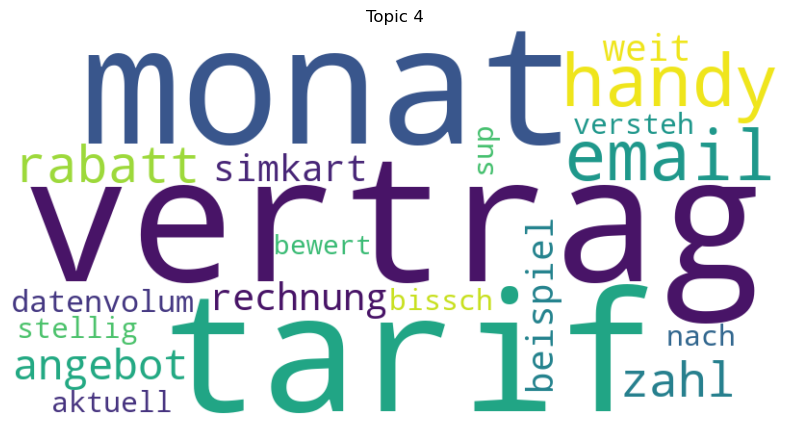

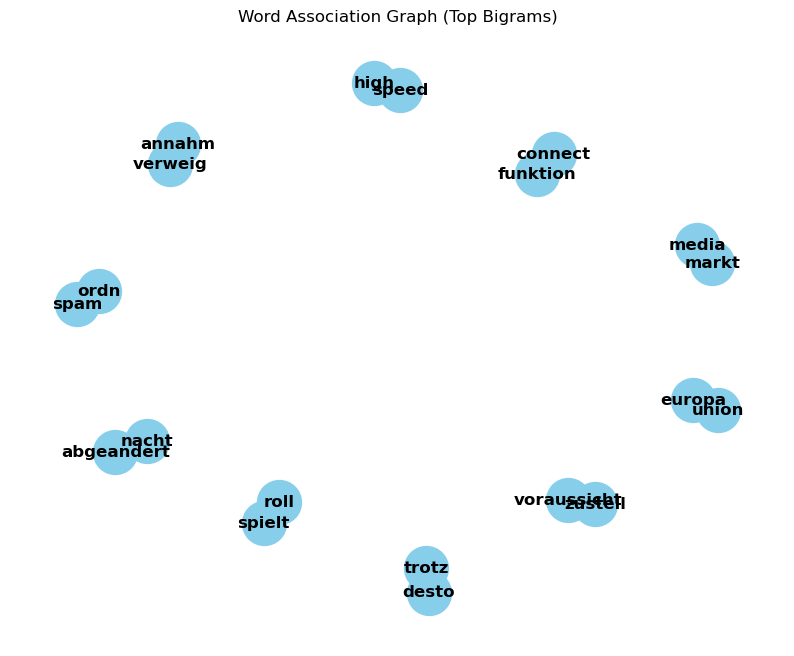

[Pipeline]  (step 1 of 1) Processing perform_topic_modeling, total=  10.1s


In [80]:
pipeline_tm.fit_transform(df_labeled)

# Building supervised learning model to classify sales

## Train-Test Split

In [18]:
features = ['content']
X_train, X_test = train_test_split(df_labeled[features + targets], test_size=0.2, random_state=42)
X_train[targets] = X_train[targets].astype('bool').astype(int)
X_test[targets] = X_test[targets].astype('bool').astype(int) 
print(len(X_train), len(X_test))

3105 777


#### Create word vectorization (Bag of Words with TfidVectorizer)

In [20]:
vectorizer = TfidfVectorizer()
train_vectors = vectorizer.fit_transform(X_train["content"])
test_vectors = vectorizer.transform(X_test["content"])
print(train_vectors.shape, test_vectors.shape)

(3105, 12267) (777, 12267)


## Models

In [21]:
def append_model(df_res, X_test, predictions, target, model_type, best_model):
    # Calculate confusion matrix
    conf_matrix = confusion_matrix(X_test[target], predictions)

    # Plot confusion matrix
    disp = ConfusionMatrixDisplay(conf_matrix, display_labels=["False", "True"])
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f'Confusion Matrix for {target}')
    plt.show()

    # the code for classification report and accuracy calculation
    class_rep = classification_report(predictions, X_test[target], output_dict=True)
    res = pd.DataFrame(class_rep)[['0', '1']].reset_index().melt(id_vars=("index"), var_name="subclass")
    res.rename({"index": "metric"}, axis=1, inplace=True)
    new_row = pd.DataFrame(["accuracy", None, class_rep["accuracy"]]).T
    new_row.columns = res.columns
    res = pd.concat((res, new_row), ignore_index=True)

    # Add target and model information to the dataframe
    res["target"] = target
    res["model"] = model_type
    res['best_model'] = best_model

    # Concatenate the results to the main dataframe
    df_res = pd.concat((df_res, res), ignore_index=True)
    df_res.to_excel("model result.xlsx", index=False)

def best_complement_naive_bayes(df_res, X_train, X_test, train_vectors, test_vectors, targets):
    # Define hyperparameter grid
    alpha_range = loguniform(1e-2,1e1)
    parameter_grid = {'alpha':alpha_range, 'norm':[True, False]}
    randomsearch_CNB = ComplementNB()
    randomsearch_clf = RandomizedSearchCV(randomsearch_CNB, parameter_grid,cv=10,scoring = "roc_auc", n_iter=50)

    for target_id in range(len(targets)):
        randomsearch_clf.fit(train_vectors, 1*X_train[targets[target_id]])
        predictions = randomsearch_clf.best_estimator_.predict(test_vectors)
        df_res = append_model(df_res, X_test, predictions, targets[target_id], "ComplementNB", randomsearch_clf.best_estimator_)
    return df_res

def best_Gaussian_NB(df_res, X_train, X_test, train_vectors, test_vectors, targets):
    for target_id in range(len(targets)):
        # no HP for GNB
        NBC = GaussianNB()
        NBC.fit(train_vectors.toarray(), 1*X_train[targets[target_id]])
        # Get predictions on the test set
        predictions = NBC.predict(test_vectors.toarray())
        df_res = append_model(df_res, X_test, predictions, targets[target_id], "GaussianNaiveBayes", NBC)
    return df_res

def best_SVC(df_res, X_train, X_test, train_vectors, test_vectors, targets):
    # Train all targets independently from one another
    # and store relevant results in data frame for later comparison
    c_range = loguniform(1e-1, 1e2)
    degree_range = np.arange(1, 5, 1)
    parameter_grid = {'C': c_range,
                      "kernel": ["linear", "poly", "rbf", "sigmoid"],
                      "degree": degree_range,
                      "gamma": ["scale", "auto"],
                      "decision_function_shape": ['ovo', 'ovr']}

    randomsearch_SVC = SVC(probability=True)
    randomsearch_clf_SVC = RandomizedSearchCV(randomsearch_SVC, parameter_grid, cv=10, scoring="roc_auc", n_iter=50)

    for target_id in range(len(targets)):
        randomsearch_clf_SVC.fit(train_vectors, 1*X_train[targets[target_id]])

        # Describe the problem in the FOCAL CELL
        # The error indicates that 'RandomizedSearchCV' object has no attribute 'best_estimator_'
        try:
            # Get predictions on the test set
            predictions = randomsearch_clf_SVC.best_estimator_.predict(test_vectors)
            df_res = append_model(df_res, X_test, predictions, targets[target_id], "SVC", randomsearch_clf_SVC.best_estimator_)
        except AttributeError as e:
            # Explain why the code is not working and how to fix it
            # 'RandomizedSearchCV' object has no attribute 'best_estimator_'
            # The RandomizedSearchCV object doesn't have a 'best_estimator_' attribute directly.
            # Use 'best_params_' to get the parameters of the best estimator found during the search.

            # print(f"AttributeError: {e}")
            # print("To fix this issue, replace 'randomsearch_clf_SVC.best_estimator_' with 'randomsearch_clf_SVC.best_params_'")

            # Continue if an error occurs
            continue
    return df_res

def best_random_forest(df_res, X_train, X_test, train_vectors, test_vectors, targets):
    parameter_grid = {"n_estimators": np.arange(80, 200, 1),
                  "min_samples_split": np.arange(2, 10, 1),
                  "min_samples_leaf": np.arange(1, 5, 1),
                  "criterion":["gini", "entropy", "log_loss"],
                  "class_weight":["balanced", "balanced_subsample",None],
                  }

    randomsearch_RFC = RandomForestClassifier()
    randomsearch_clf_RFC = RandomizedSearchCV(randomsearch_RFC, parameter_grid,cv=10,scoring = "roc_auc", n_iter=100)

    for target_id in range(len(targets)):
        randomsearch_clf_RFC.fit(train_vectors, 1*X_train[targets[target_id]])
        predictions = randomsearch_clf_RFC.best_estimator_.predict(test_vectors)
        df_res = append_model(df_res, X_test, predictions, targets[target_id], "RandomForest", randomsearch_clf_RFC.best_estimator_)
    return df_res

def best_adaboost(df_res, X_train, X_test, train_vectors, test_vectors, targets):
    parameter_grid = {"n_estimators": np.arange(30, 100, 1),
                  "learning_rate": loguniform(1e-1, 1e1)
                  }

    randomsearch_ABC = AdaBoostClassifier()
    randomsearch_clf_ABC = RandomizedSearchCV(randomsearch_ABC, parameter_grid,cv=10,scoring = "roc_auc", n_iter=20)

    for target_id in range(len(targets)):
        randomsearch_clf_ABC.fit(train_vectors, 1*X_train[targets[target_id]])
        # Get predictions on the test set
        predictions = randomsearch_clf_ABC.best_estimator_.predict(test_vectors)
        df_res = append_model(df_res, X_test, predictions, targets[target_id], "AdaBoost", randomsearch_clf_ABC.best_estimator_)
    return df_res

def best_gaussian_process(df_res, X_train, X_test, train_vectors, test_vectors, targets):
    parameter_grid = {"kernel": [1.0 * RBF(length_scale=1.15), 1.0 * DotProduct(sigma_0=1.0) ** 2]}

    # gridsearch since we're comparing exactly two settings
    randomsearch_GPC = GaussianProcessClassifier()
    randomsearch_clf_GPC = RandomizedSearchCV(randomsearch_GPC, parameter_grid,cv=2,scoring = "roc_auc")

    for target_id in range(len(targets)):
        randomsearch_clf_GPC.fit(train_vectors.toarray(),np.array(1*X_train[targets[target_id]]))
        # Get predictions on the test set
        predictions = randomsearch_clf_GPC.best_estimator_.predict(test_vectors.toarray())
        df_res = append_model(df_res, X_test, predictions, targets[target_id], "GaussianProcess", randomsearch_clf_GPC.best_estimator_)
    return df_res

def best_knn(df_res, X_train, X_test, train_vectors, test_vectors, targets):
    parameter_grid = {
    "n_neighbors": [3, 5, 7, 9, 11],
    "weights": ["uniform", "distance"],
    "p": [1, 2],
    }

    randomsearch_KNN = KNeighborsClassifier()
    randomsearch_clf_KNN = RandomizedSearchCV(
        randomsearch_KNN, parameter_grid, cv=10, scoring="roc_auc", n_iter=100
    )

    for target_id in range(len(targets)):
        randomsearch_clf_KNN.fit(train_vectors, 1*X_train[targets[target_id]])
        # Get predictions on the test set
        predictions = randomsearch_clf_KNN.best_estimator_.predict(test_vectors)
        df_res = append_model(df_res, X_test, predictions, targets[target_id], "KNeighborsClassifier", randomsearch_clf_KNN.best_estimator_)
    return df_res

def bert(df_res, X_train, X_test, train_vectors, test_vectors, targets):
    model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=num_labels)
    # add BERT stuff here so it can be compared with the other models.
    

def evaluate_models(df_res, targets, metric='roc_auc'):
    for variable in targets:
        # Filter the data based on conditions
        filtered_data = df_res.loc[(df_res["metric"] == metric) & (df_res["target"] == variable)]

        # Check if there is data after filtering
        if not filtered_data.empty:
            # Create the bar plot
            ax = sns.barplot(data=filtered_data, x="model", y="value")

            # Set plot title and labels
            plt.title(f"(test) {metric} per model for {variable}")
            plt.ylabel(metric)

            # Rotate x-axis labels for better visibility
            ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')

            # Show the plot
            plt.show()
        else:
            print(f"No data for {variable}")
    
    filtered_data = df_res.loc[(df_res["metric"]=="support") & (df_res["model"]=="ComplementNB")]
    ax = sns.barplot(data=filtered_data, x="target", y="value", hue="subclass")
    plt.title(f"(test) support for variables")
    plt.ylabel("support")
    plt.show()
    
def select_best_models(X_train, X_test, train_vectors, test_vectors, models, targets, metric='roc_auc'):
    df_res = pd.DataFrame()
    if 'CNB' in models:
        df_res = best_complement_naive_bayes(df_res, X_train, X_test, train_vectors, test_vectors, targets)
    if 'NB' in models:
        df_res = best_Gaussian_NB(df_res, X_train, X_test, train_vectors, test_vectors, targets)
    if 'SVC' in models:
        df_res = best_SVC(df_res, X_train, X_test, train_vectors, test_vectors, targets)
    if 'RF' in models:
        df_res = best_random_forest(df_res, X_train, X_test, train_vectors, test_vectors, targets)
    if 'ADA' in models:
        df_res = best_adaboost(df_res, X_train, X_test, train_vectors, test_vectors, targets)
    if 'GP' in models:
        df_res = best_gaussian_process(df_res, X_train, X_test, train_vectors, test_vectors, targets)
    if 'KNN' in models:
        df_res = best_knn(df_res, X_train, X_test, train_vectors, test_vectors, targets)
    if 'BERT' in models:
        df_res = bert(df_res, X_train, X_test, train_vectors, test_vectors, targets)
    evaluate_models(df_res, targets, metric)
    return df_res[(df_res.target.isin(targets))&(df_res.metric==metric)][['target', 'best_model', 'metric']].copy()

In [ ]:
pipeline_models = Pipeline([('select_best_models', FunctionTransformer(
        select_best_models, kw_args={
            'X_train': X_train,
            'X_test': X_test,
            'train_vectors': train_vectors,
            'test_vectors': test_vectors,
            'models': ['CNB', 'NB', 'SVC', 'RF', 'ADA', 'GP', 'KNN', 'BERT'],
            'targets': targets, 
            'metric': 'roc_auc'}))], verbose = True)


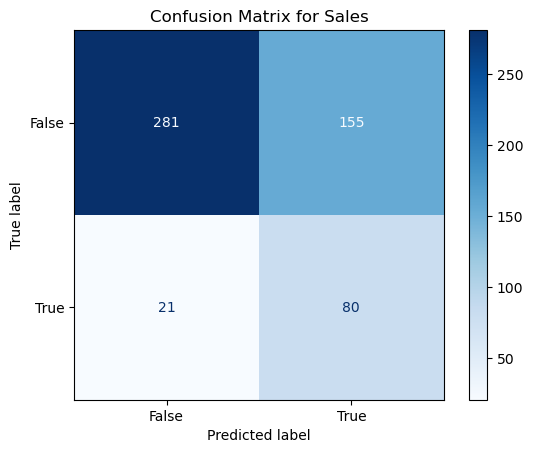

{'0': {'precision': 0.6444954128440367, 'recall': 0.9304635761589404, 'f1-score': 0.7615176151761518, 'support': 302}, '1': {'precision': 0.7920792079207921, 'recall': 0.3404255319148936, 'f1-score': 0.4761904761904762, 'support': 235}, 'accuracy': 0.6722532588454376, 'macro avg': {'precision': 0.7182873103824143, 'recall': 0.635444554036917, 'f1-score': 0.618854045683314, 'support': 537}, 'weighted avg': {'precision': 0.709080500075019, 'recall': 0.6722532588454376, 'f1-score': 0.6366537834040219, 'support': 537}}


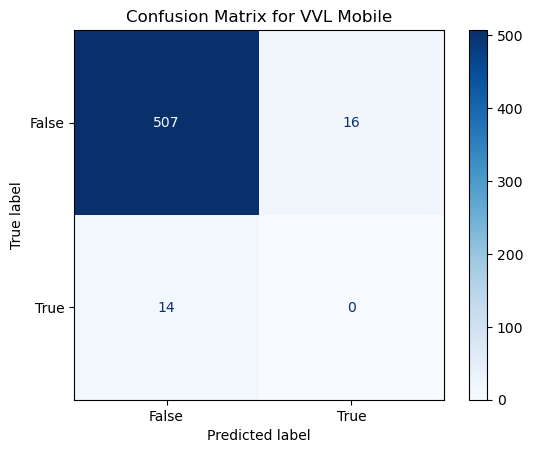

{'0': {'precision': 0.9694072657743786, 'recall': 0.9731285988483686, 'f1-score': 0.971264367816092, 'support': 521}, '1': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 16}, 'accuracy': 0.9441340782122905, 'macro avg': {'precision': 0.4847036328871893, 'recall': 0.4865642994241843, 'f1-score': 0.485632183908046, 'support': 537}, 'weighted avg': {'precision': 0.9405236228462779, 'recall': 0.9441340782122905, 'f1-score': 0.9423253922387038, 'support': 537}}


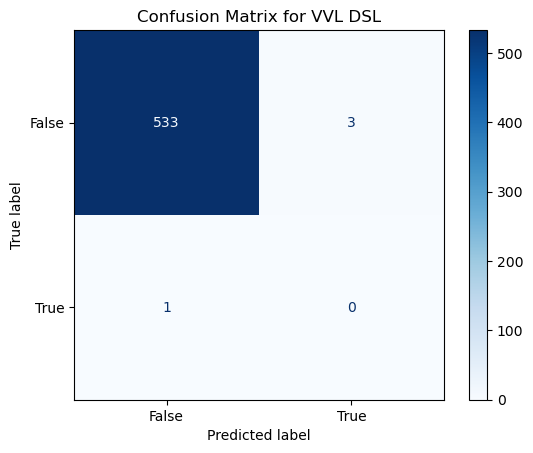

{'0': {'precision': 0.9944029850746269, 'recall': 0.99812734082397, 'f1-score': 0.9962616822429907, 'support': 534}, '1': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 3}, 'accuracy': 0.9925512104283054, 'macro avg': {'precision': 0.49720149253731344, 'recall': 0.499063670411985, 'f1-score': 0.49813084112149536, 'support': 537}, 'weighted avg': {'precision': 0.9888476611356626, 'recall': 0.9925512104283054, 'f1-score': 0.9906959745209629, 'support': 537}}


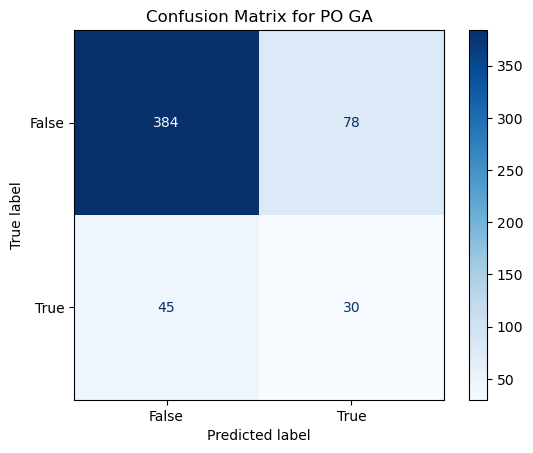

{'0': {'precision': 0.8311688311688312, 'recall': 0.8951048951048951, 'f1-score': 0.861952861952862, 'support': 429}, '1': {'precision': 0.4, 'recall': 0.2777777777777778, 'f1-score': 0.3278688524590164, 'support': 108}, 'accuracy': 0.770949720670391, 'macro avg': {'precision': 0.6155844155844157, 'recall': 0.5864413364413364, 'f1-score': 0.5949108572059392, 'support': 537}, 'weighted avg': {'precision': 0.7444533120510775, 'recall': 0.770949720670391, 'f1-score': 0.754539318144044, 'support': 537}}


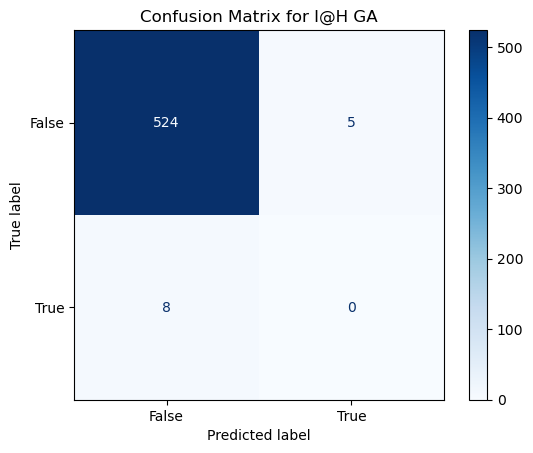

{'0': {'precision': 0.9905482041587902, 'recall': 0.9849624060150376, 'f1-score': 0.9877474081055608, 'support': 532}, '1': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 5}, 'accuracy': 0.9757914338919925, 'macro avg': {'precision': 0.4952741020793951, 'recall': 0.4924812030075188, 'f1-score': 0.4938737040527804, 'support': 537}, 'weighted avg': {'precision': 0.9813252227420416, 'recall': 0.9757914338919925, 'f1-score': 0.9785505048643545, 'support': 537}}


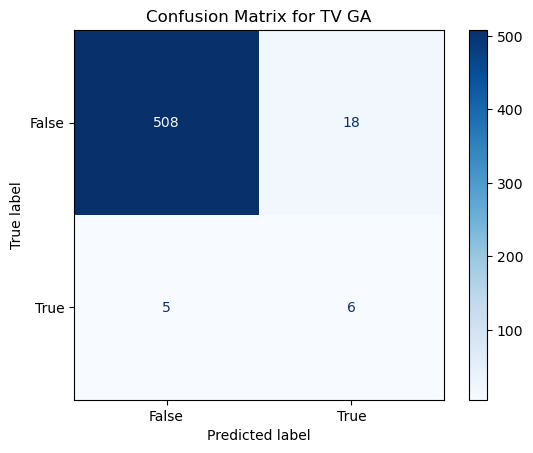

{'0': {'precision': 0.9657794676806084, 'recall': 0.9902534113060428, 'f1-score': 0.9778633301251203, 'support': 513}, '1': {'precision': 0.5454545454545454, 'recall': 0.25, 'f1-score': 0.34285714285714286, 'support': 24}, 'accuracy': 0.957169459962756, 'macro avg': {'precision': 0.7556170065675769, 'recall': 0.6201267056530214, 'f1-score': 0.6603602364911316, 'support': 537}, 'weighted avg': {'precision': 0.9469939962962033, 'recall': 0.957169459962756, 'f1-score': 0.9494831653310207, 'support': 537}}
[Pipeline]  (step 1 of 10) Processing best_complement_naive_bayes, total=  19.5s


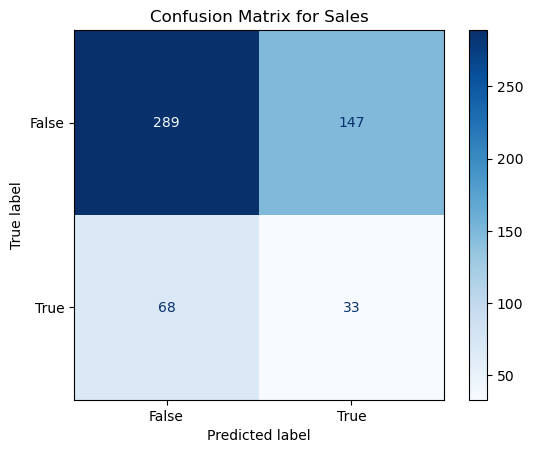

{'0': {'precision': 0.6628440366972477, 'recall': 0.8095238095238095, 'f1-score': 0.7288776796973517, 'support': 357}, '1': {'precision': 0.32673267326732675, 'recall': 0.18333333333333332, 'f1-score': 0.23487544483985764, 'support': 180}, 'accuracy': 0.5996275605214153, 'macro avg': {'precision': 0.49478835498228724, 'recall': 0.49642857142857144, 'f1-score': 0.4818765622686047, 'support': 537}, 'weighted avg': {'precision': 0.5501810098492295, 'recall': 0.5996275605214153, 'f1-score': 0.563290338404337, 'support': 537}}


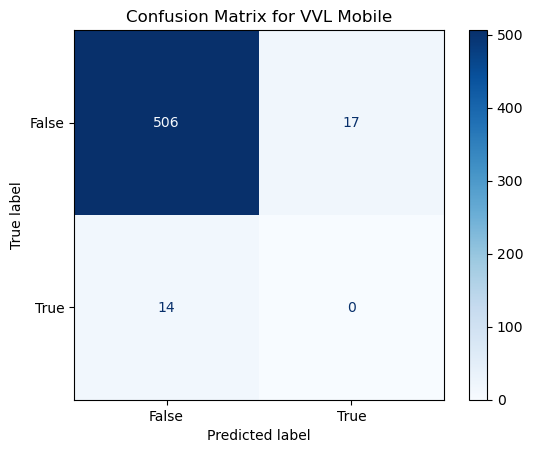

{'0': {'precision': 0.9674952198852772, 'recall': 0.9730769230769231, 'f1-score': 0.9702780441035475, 'support': 520}, '1': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 17}, 'accuracy': 0.9422718808193669, 'macro avg': {'precision': 0.4837476099426386, 'recall': 0.48653846153846153, 'f1-score': 0.4851390220517737, 'support': 537}, 'weighted avg': {'precision': 0.9368668795909575, 'recall': 0.9422718808193669, 'f1-score': 0.9395616069531558, 'support': 537}}


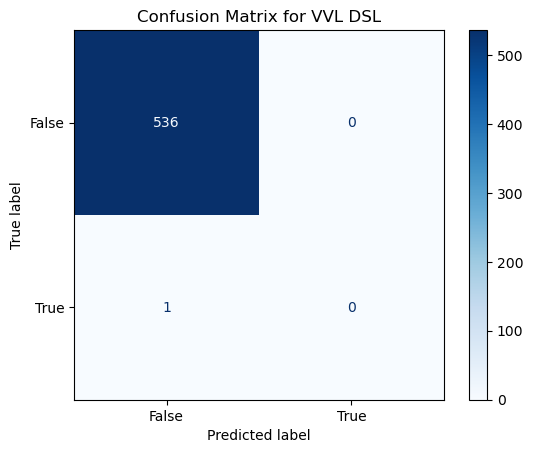

{'0': {'precision': 1.0, 'recall': 0.9981378026070763, 'f1-score': 0.9990680335507922, 'support': 537}, '1': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 0}, 'accuracy': 0.9981378026070763, 'macro avg': {'precision': 0.5, 'recall': 0.49906890130353815, 'f1-score': 0.4995340167753961, 'support': 537}, 'weighted avg': {'precision': 1.0, 'recall': 0.9981378026070763, 'f1-score': 0.9990680335507922, 'support': 537}}


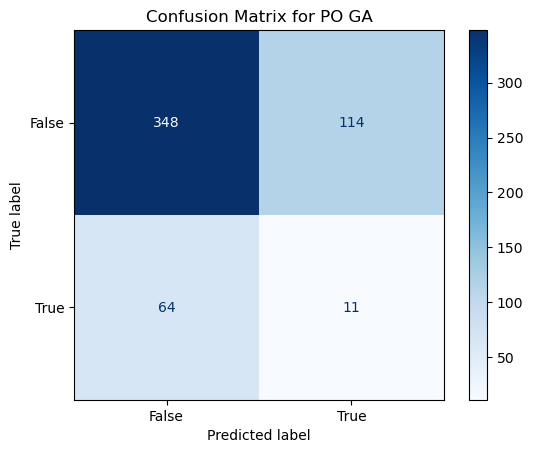

{'0': {'precision': 0.7532467532467533, 'recall': 0.8446601941747572, 'f1-score': 0.7963386727688786, 'support': 412}, '1': {'precision': 0.14666666666666667, 'recall': 0.088, 'f1-score': 0.10999999999999999, 'support': 125}, 'accuracy': 0.6685288640595903, 'macro avg': {'precision': 0.44995670995671, 'recall': 0.4663300970873786, 'f1-score': 0.4531693363844393, 'support': 537}, 'weighted avg': {'precision': 0.6120502712681483, 'recall': 0.6685288640595903, 'f1-score': 0.6365764118822681, 'support': 537}}


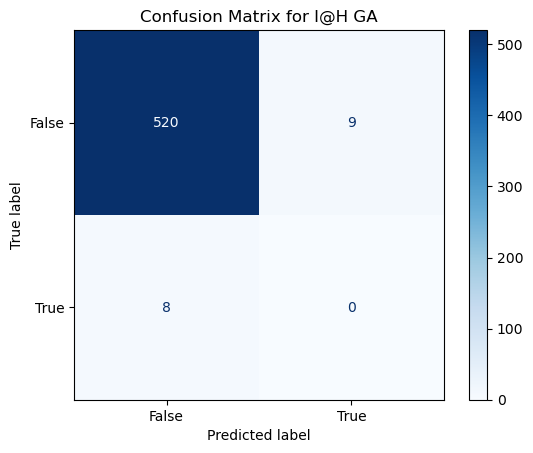

{'0': {'precision': 0.9829867674858223, 'recall': 0.9848484848484849, 'f1-score': 0.9839167455061494, 'support': 528}, '1': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 9}, 'accuracy': 0.9683426443202979, 'macro avg': {'precision': 0.4914933837429111, 'recall': 0.49242424242424243, 'f1-score': 0.4919583727530747, 'support': 537}, 'weighted avg': {'precision': 0.9665121289246074, 'recall': 0.9683426443202979, 'f1-score': 0.96742652072113, 'support': 537}}


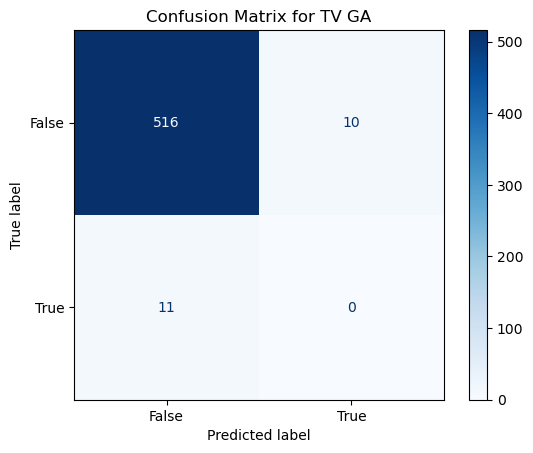

{'0': {'precision': 0.9809885931558935, 'recall': 0.9791271347248577, 'f1-score': 0.9800569800569799, 'support': 527}, '1': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 10}, 'accuracy': 0.9608938547486033, 'macro avg': {'precision': 0.49049429657794674, 'recall': 0.48956356736242884, 'f1-score': 0.49002849002848997, 'support': 537}, 'weighted avg': {'precision': 0.962720649149266, 'recall': 0.9608938547486033, 'f1-score': 0.9618063845251925, 'support': 537}}
[Pipeline] . (step 2 of 10) Processing best_Gaussian_NB, total=   4.9s


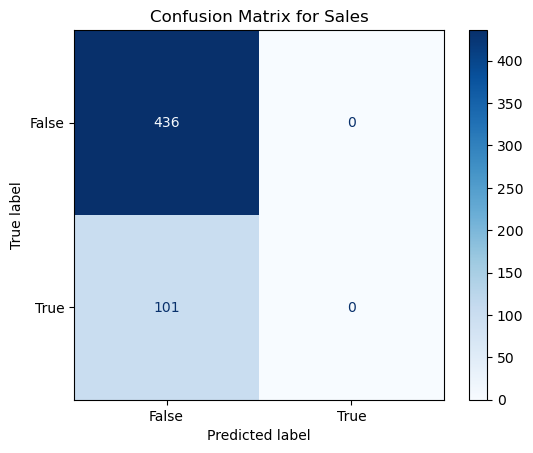

{'0': {'precision': 1.0, 'recall': 0.8119180633147114, 'f1-score': 0.8961973278520041, 'support': 537}, '1': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 0}, 'accuracy': 0.8119180633147114, 'macro avg': {'precision': 0.5, 'recall': 0.4059590316573557, 'f1-score': 0.44809866392600206, 'support': 537}, 'weighted avg': {'precision': 1.0, 'recall': 0.8119180633147114, 'f1-score': 0.8961973278520041, 'support': 537}}


In [ ]:
selected_models = pipeline_models.fit_transform() 

In [ ]:
df_res

## Predict unlabeled data

In [ ]:
for variable in targets:
    df_unlabeled[variable] = selected_models[selected_models.target==variable].best_model.predict(df_unlabeled[features])

## Bert Model

### Move this stuff to the modeling section above

In [ ]:
pip install flax

In [ ]:
pip install tensorflow

In [ ]:
pip install torch

In [1]:
import pandas as pd

from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, roc_curve
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split

from transformers import BertTokenizer, BertForSequenceClassification, AdamW

In [2]:
# df = pd.read_csv('bq-results-20230912-113230-1694518407919.csv')
# df_labeled =  pd.read_excel('1 - 2500 Fertig 1.xlsx')

In [7]:
df_labeled.columns

Index(['AP', 'Ariadne_internal_ID', 'content', 'cnt', 'VVL Mobile', 'VVL DSL',
       'PO GA', 'I@H GA', 'TV GA', 'OOC (out of category)', 'Comment',
       'Conditional Formatting', 'Bearbeitungszeit'],
      dtype='object')

In [8]:
label_columns = targets
num_labels = len(label_columns)
df_labeled[label_columns] = df_labeled[label_columns].astype(int)

In [9]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=num_labels)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
train_df, val_df = train_test_split(df_labeled, test_size=0.2, random_state=42)

In [ ]:
train_data = prepare_dataset(train_df, tokenizer, label_columns)
val_data = prepare_dataset(val_df, tokenizer, label_columns)

# Create data loaders
train_loader = DataLoader(train_data, batch_size=8, shuffle=True)
val_loader = DataLoader(val_data, batch_size=8, shuffle=False)

# Set up the training loop
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

optimizer = AdamW(model.parameters(), lr=2e-5)
criterion = nn.BCEWithLogitsLoss()  # Binary Cross Entropy Loss with Logits for multi-label classification

# Training loop
num_epochs = 3

for epoch in range(num_epochs):
    model.train()
    total_loss = 0

    for batch in train_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        optimizer.zero_grad()

        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        total_loss += loss.item()

        loss.backward()
        optimizer.step()

    average_loss = total_loss / len(train_loader)
    print(f'Epoch {epoch + 1}/{num_epochs}, Training Loss: {average_loss}')

# Validation loop
model.eval()
total_correct = 0

with torch.no_grad():
    for batch in val_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids, attention_mask=attention_mask)
        predictions = torch.sigmoid(outputs.logits)  # Apply sigmoid to get probabilities
        predictions = (predictions > 0.5).float()  # Convert probabilities to binary predictions

        total_correct += (predictions == labels).sum().item()

accuracy = total_correct / len(val_data)
print(f'Validation Accuracy: {accuracy * 100:.2f}%')